In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import GMM
import EM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA
from sklearn import random_projection, preprocessing
from sklearn.cluster import KMeans, SpectralClustering, BisectingKMeans
from sklearn.metrics import homogeneity_score
from ucimlrepo import fetch_ucirepo 
from sklearn import preprocessing

In [3]:
def load_mines() -> pd.DataFrame:
    # fetch dataset 
    land_mines = fetch_ucirepo(id=763) 
    y = land_mines.data.targets
    X = land_mines.data.features
    # data (as pandas dataframes) 
    df = pd.concat([y.M, X], axis=1)
    return df

mines = load_mines()


def save_mines_as_csv(file_name='mines.csv'):
    land_mines = fetch_ucirepo(id=763) 
    y = land_mines.data.targets
    X = land_mines.data.features
    # data (as pandas dataframes) 
    df = pd.concat([y.M, X], axis=1)
    df[['S', 'H', 'V', 'M']].to_csv(file_name, index=False)

save_mines_as_csv()

                M           V           H           S
count  338.000000  338.000000  338.000000  338.000000
mean     2.952663    0.430634    0.508876    0.503550
std      1.419703    0.195819    0.306043    0.344244
min      1.000000    0.197734    0.000000    0.000000
25%      2.000000    0.309737    0.272727    0.200000
50%      3.000000    0.359516    0.545455    0.600000
75%      4.000000    0.482628    0.727273    0.800000
max      5.000000    0.999999    1.000000    1.000000


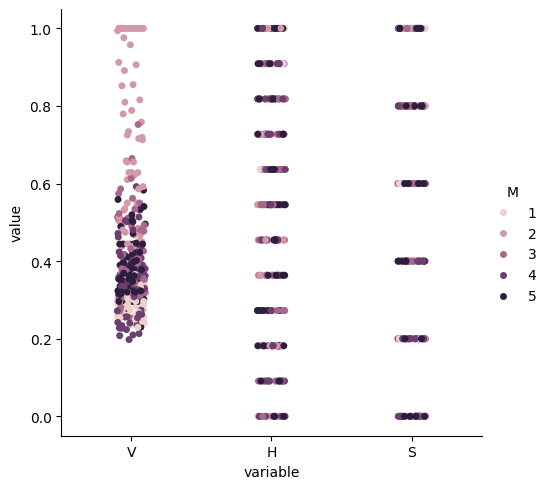

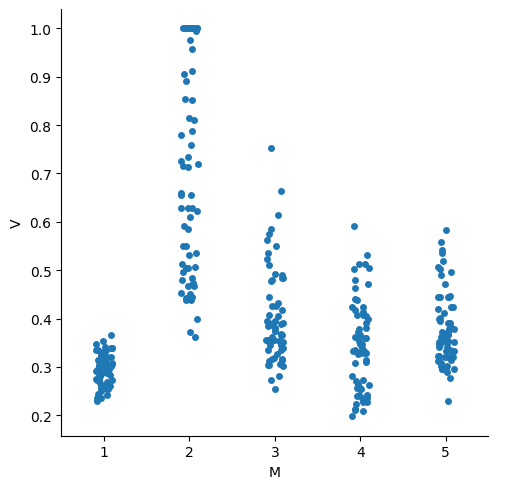

In [4]:
print(mines.describe())
sns.catplot(mines.melt(id_vars='M'), x='variable', y='value', hue='M')
sns.catplot(mines, x='M', y='V')

<Axes: xlabel='H', ylabel='V'>

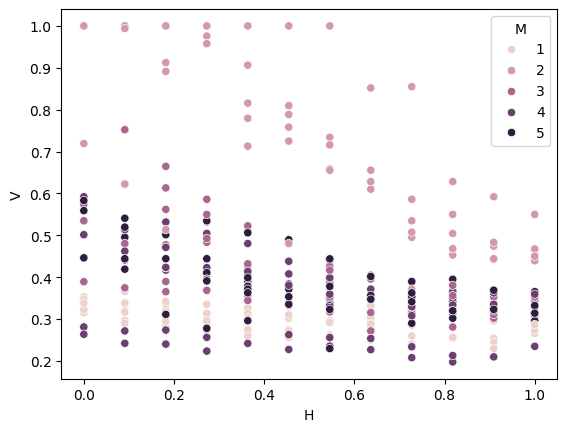

In [5]:
sns.scatterplot(mines, y='V', x='H', hue='M')

<Axes: >

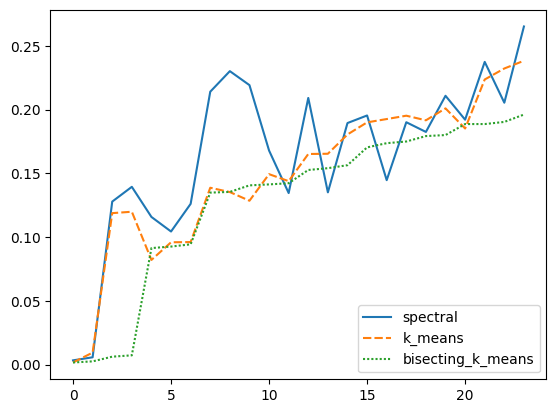

In [6]:
#K Means
X, y = mines[['V', 'S', 'H']], mines['M']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
spectral_scores = []
k_means_scores = []
bisecting_scores = []
for n in range(2, 26):
    k_model = KMeans(n_clusters=n, random_state=123).fit(X_train)
    k_means_scores.append(homogeneity_score(y_train, k_model.labels_))
    spectral_model = SpectralClustering(n_clusters=n, random_state=123).fit(X_train)
    spectral_scores.append(homogeneity_score(y_train, spectral_model.labels_)) 
    bisecting_model = BisectingKMeans(n_clusters=n, random_state=123).fit(X_train)
    bisecting_scores.append(homogeneity_score(y_train, bisecting_model.labels_)) 



scores_df = pd.DataFrame({'spectral': spectral_scores, 'k_means': k_means_scores, 'bisecting_k_means': bisecting_scores})


sns.lineplot(scores_df)

            V    S         H  cluster
0    0.338157  0.0  0.000000        2
1    0.320241  0.0  0.181818        2
2    0.287009  0.0  0.272727        2
3    0.256284  0.0  0.454545        2
4    0.262840  0.0  0.545455       11
..        ...  ...       ...      ...
333  0.323262  0.4  0.909091        7
334  0.444108  1.0  0.181818       10
335  0.353474  1.0  0.454545        5
336  0.362537  1.0  0.727273        5
337  0.314199  1.0  1.000000        4

[338 rows x 4 columns]


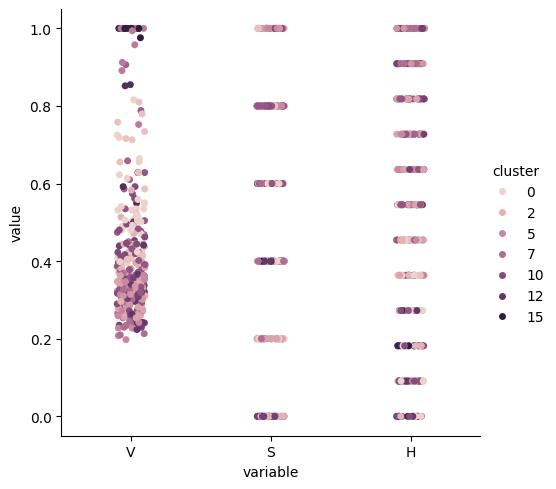

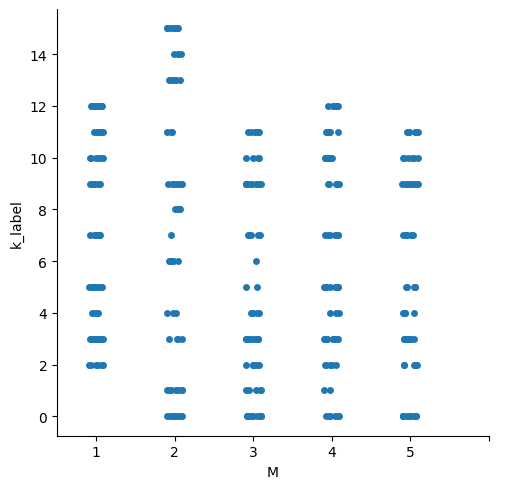

In [7]:
#we will use 13
k_means_mines_model = SpectralClustering(n_clusters=16, random_state=123).fit(X)

clustering_df = X.copy(deep=True)

clustering_df['cluster'] = k_means_mines_model.labels_
print(clustering_df)
sns.catplot(clustering_df.melt(id_vars='cluster'), x='variable', y='value', hue='cluster')
g = sns.catplot(pd.DataFrame({'M': y, 'k_label':k_means_mines_model.labels_}), x='M', y='k_label')
g.set(xticks=[0, 1, 2, 3, 4, 5])

<Axes: xlabel='H', ylabel='V'>

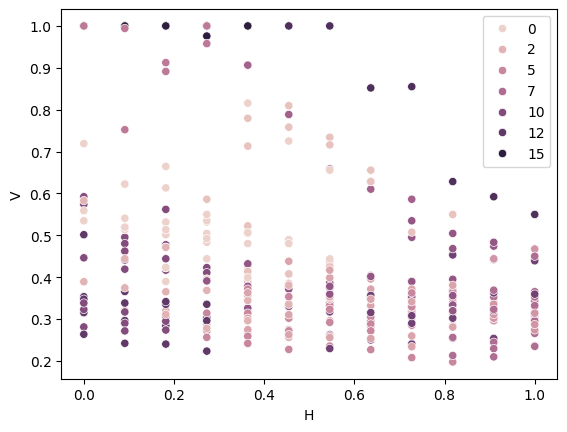

In [8]:
sns.scatterplot(X, y='V', x='H', hue=k_means_mines_model.labels_)

0.23745728133861108

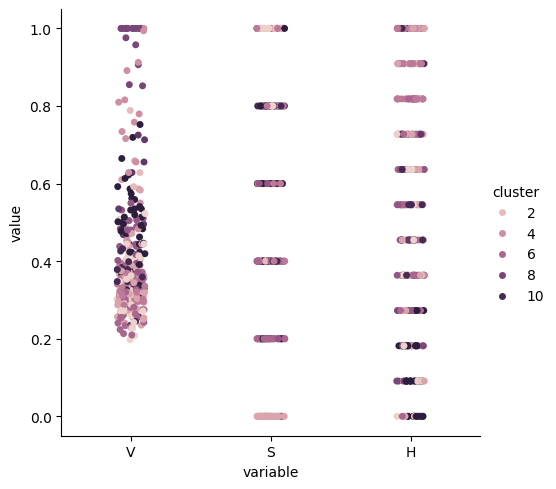

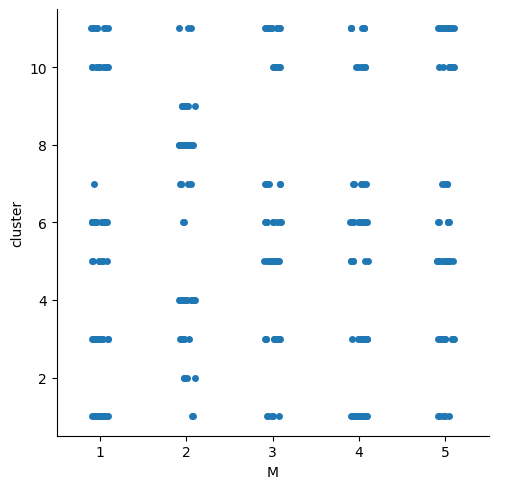

In [9]:
#load em results for mines
mines_em = pd.read_csv('mines_em_k_16.csv')

mines_em.describe()
sns.catplot(mines_em[['V', 'S', 'H', 'cluster']].melt(id_vars='cluster'), x='variable', y='value', hue='cluster')
sns.catplot(mines_em, x='M', y='cluster')
homogeneity_score(mines_em['M'], mines_em['cluster'])


<Axes: xlabel='k', ylabel='llh'>

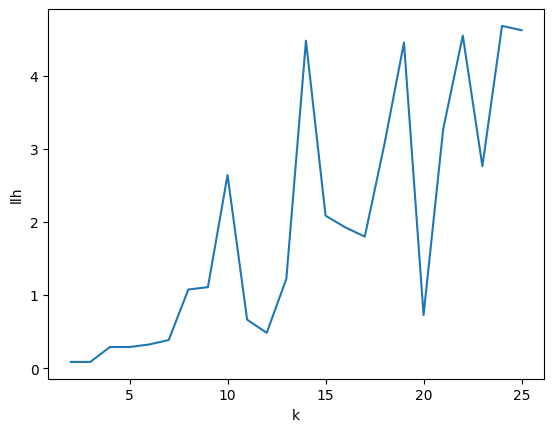

In [10]:
#plot max llh for em
llh_k = pd.read_csv('mines_llh_for_k.csv')
sns.lineplot(llh_k, x='k', y='llh')

<Axes: xlabel='iter', ylabel='llh'>

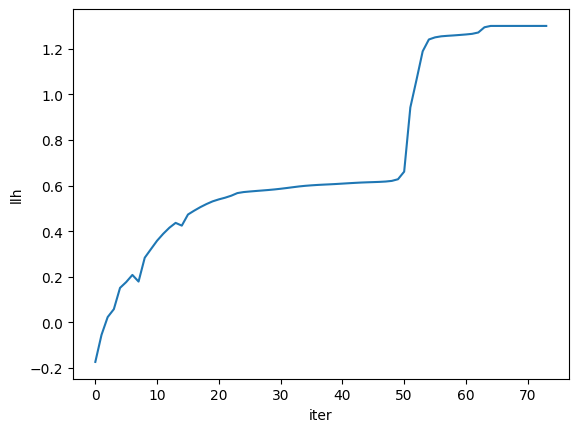

In [11]:
#plot llh for selected k val
llh_for_selected_k = pd.read_csv('mines_llh_k_16.csv')
sns.lineplot(llh_for_selected_k.reset_index(names='iter'), y='llh', x='iter')

[1.38950736]
[1.38950736 1.00044394]
[1.38950736 1.00044394 0.61895078]
[0.4617987974860446, 0.7942934786904985, 0.9999999999999999]


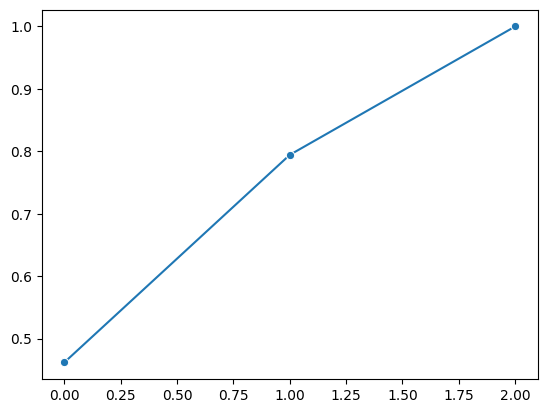

In [12]:
#dimensionality reduction
mines_df = load_mines()
X, y = mines_df[['V', 'H', 'S']], mines_df['M']
X_centered = preprocessing.StandardScaler().fit_transform(X)
explained_var_ratio = []

for i in range(1, 4):
    pca = PCA(n_components=i, whiten=True)
    pca.fit(X_centered)
    print(pca.explained_variance_)
    explained_var_ratio.append(sum(pca.explained_variance_ratio_))


sns.lineplot(explained_var_ratio, marker='o')
print(explained_var_ratio)

<Axes: xlabel='pca0', ylabel='pca1'>

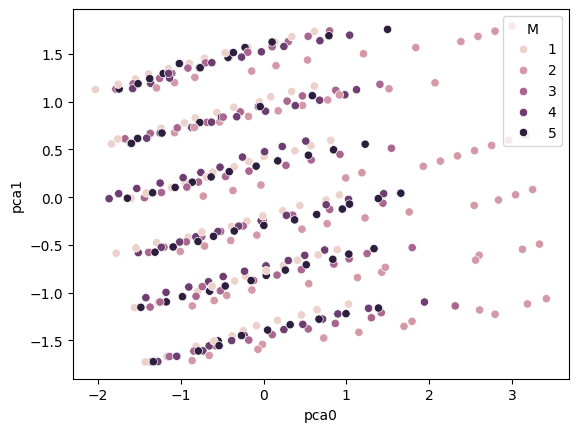

In [13]:
mines_df = load_mines()
X, y = mines_df[['V', 'H', 'S']], mines_df['M']
X_centered = preprocessing.StandardScaler().fit_transform(X)
mines_pca = PCA(2)

mines_pca_df = pd.DataFrame(mines_pca.fit_transform(X_centered), columns=mines_pca.get_feature_names_out())
mines_pca_df['M'] = y.astype('int32')

mines_pca_df.astype({'M': 'int64'})
mines_pca_df.to_csv('mines_pca.csv', index=False)
sns.scatterplot(mines_pca_df, x='pca0', y='pca1', hue='M')

<Axes: xlabel='fastica0', ylabel='fastica1'>

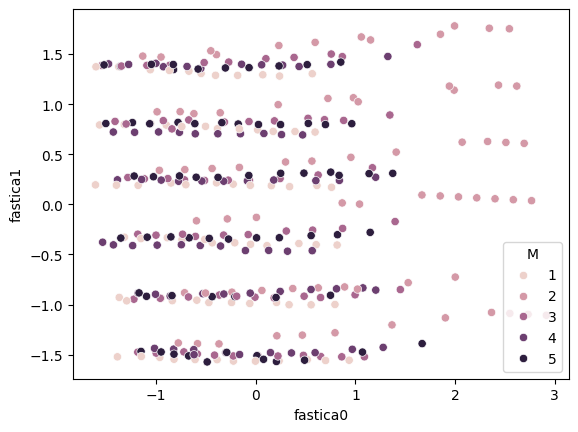

In [14]:
#dimensionality reduction
mines_df = load_mines()
X, y = mines_df[['V', 'H', 'S']], mines_df['M']

#center data 
X_centered = preprocessing.StandardScaler().fit_transform(X)

ica = FastICA(random_state=123, n_components=2)
mines_ica_df = pd.DataFrame(ica.fit_transform(X_centered), columns=ica.get_feature_names_out())
mines_ica_df['M'] = y.astype('int32')

mines_ica_df.astype({'M': 'int64'})

mines_ica_df.to_csv('mines_ica.csv', index=False)
sns.scatterplot(mines_ica_df, y='fastica1', x='fastica0', hue='M')


In [15]:
#dimensionality reduction
mines_df = load_mines()
X, y = mines_df[['V', 'H', 'S']], mines_df['M']
'''
#center data 
X_centered = preprocessing.StandardScaler().fit_transform(X)

ica = FastICA(random_state=123, n_components=3)
mines_ica_df = pd.DataFrame(ica.fit_transform(X_centered), columns=ica.get_feature_names_out())
mines_ica_df['M'] = y.astype('int32')

mines_ica_df.astype({'M': 'int64'})

mines_ica_df.to_csv('ica_mines_3.csv')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mines_ica_df['fastica0'], mines_ica_df['fastica1'], mines_ica_df['fastica2'], c=mines_ica_df['M'], cmap='viridis', marker='o')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.title('ICA Colored by M')
plt.show()'''

"\n#center data \nX_centered = preprocessing.StandardScaler().fit_transform(X)\n\nica = FastICA(random_state=123, n_components=3)\nmines_ica_df = pd.DataFrame(ica.fit_transform(X_centered), columns=ica.get_feature_names_out())\nmines_ica_df['M'] = y.astype('int32')\n\nmines_ica_df.astype({'M': 'int64'})\n\nmines_ica_df.to_csv('ica_mines_3.csv')\n\nfig = plt.figure(figsize=(8, 6))\nax = fig.add_subplot(111, projection='3d')\nax.scatter(mines_ica_df['fastica0'], mines_ica_df['fastica1'], mines_ica_df['fastica2'], c=mines_ica_df['M'], cmap='viridis', marker='o')\n\nax.set_xlabel('X-axis')\nax.set_ylabel('Y-axis')\nax.set_zlabel('Z-axis')\nplt.title('ICA Colored by M')\nplt.show()"

     gaussianrandomprojection0  gaussianrandomprojection1  M
0                    -1.104422                  -0.525623  1
1                    -0.614492                  -0.671454  1
2                    -0.274223                  -0.612137  1
3                     0.265999                  -0.688190  1
4                     0.450056                  -0.845614  1
..                         ...                        ... ..
333                   1.284869                  -0.302713  5
334                  -0.518675                   2.051028  5
335                   0.466549                   2.179608  5
336                   1.060356                   1.765102  5
337                   1.879524                   1.663283  5

[338 rows x 3 columns]


<Axes: xlabel='gaussianrandomprojection0', ylabel='gaussianrandomprojection1'>

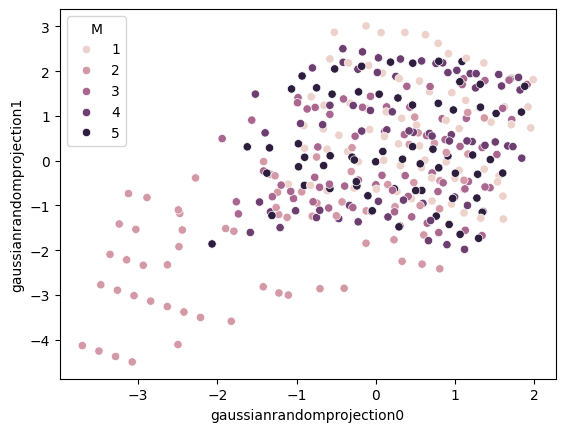

In [16]:
#dimensionality reduction
mines_df = load_mines()
X, y = mines_df[['V', 'H', 'S']], mines_df['M']

#center data 
X_centered = preprocessing.StandardScaler().fit_transform(X)

mines_rp = random_projection.GaussianRandomProjection(n_components=2, random_state=123)

mines_rp_df = pd.DataFrame(mines_rp.fit_transform(X_centered), columns=mines_rp.get_feature_names_out())
mines_rp_df['M'] = y.astype('int32')
print(mines_rp_df)

sns.scatterplot(mines_rp_df, x='gaussianrandomprojection0', y='gaussianrandomprojection1', hue='M')

<Axes: xlabel='pca0', ylabel='pca1'>

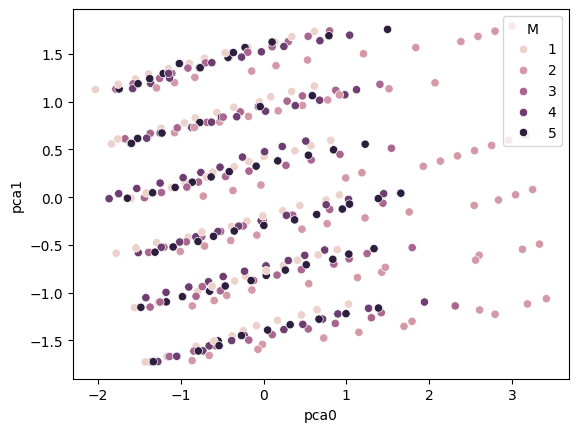

In [17]:
mines_pca_em = pd.read_csv('mines_pca_em.csv')
homogeneity_score(mines_pca_em['M'], mines_pca_em['cluster'])

sns.scatterplot(mines_pca_df, x='pca0', y='pca1', hue='M')

In [18]:
mines_ica_em = pd.read_csv('mines_ica_em.csv')
homogeneity_score(mines_ica_em['M'], mines_ica_em['cluster'])

0.15930328966887836